In [8]:
import os
import sys
import json

import random
import numpy as np
import scipy as sp
import pandas as pd

from collections import Counter, defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics

In [38]:
def compute_matrices(m1, m2, num_reports):
    print(m1.shape)
    print(m2.shape)
    A = (m1.T @ m2)
    B = (m1.sum(0).reshape((m1.shape[1],1)) - A)
    B[B==0] = 1
    C = (m2.sum(0) - A)
    C[C==0] = 1
    D = (num_reports-(A+B+C))
    
    PRR = ((A/B)/(C/D))
    Tc = A/(A+B+C)

    return {
        'A': A,
        'B': B,
        'C': C,
        'D': D,
        'PRR': PRR,
        'Tc': Tc
    }

def build_dataframe(matrices, ordered_m1, m1_name, ordered_m2, m2_name, m12label=None, m22label=None, minA=10):
    
    mask = matrices['A']>=minA
    indices = np.where(mask)
    dfdata = {}

    dfdata[m1_name] = [ordered_m1[i] for i in indices[0]]
    if m12label is not None:
        dfdata[f"{m1_name}_label"] = [m12label.get(ordered_m1[i], i) for i in indices[0]]
    
    dfdata[m2_name] = [ordered_m2[i] for i in indices[1]]
    if m22label is not None:
        dfdata[f"{m2_name}_label"] = [m22label.get(ordered_m2[i], i) for i in indices[1]]

    for key, mat in matrices.items():
        dfdata[key] = mat[mask]

    return pd.DataFrame(dfdata)

In [5]:
dataset_name = 'o3UlI0k1'
output_path = os.path.join('..', 'outputs', dataset_name)
dataset_path = os.path.join('..', 'data', dataset_name)

os.path.exists(output_path), os.path.exists(dataset_path)

(True, True)

In [10]:
config_path = os.path.join(dataset_path, 'config.json')
if not os.path.exists(config_path):
    raise Exception(f"No config file found at: {config_path}")
config = json.load(open(config_path))

In [6]:
final_predictions = np.load(os.path.join(output_path, 'final_predictions.npy'))
final_predictions.shape

(100, 1050000)

In [16]:
# Get dimensions from config
ndrugs = config['ndrugs']
nreactions = config['nreactions']
nindications = config['nindications']
nreports = config['nreports']

# Calculate start indices for each section
drugs_end = ndrugs
reactions_end = drugs_end + nreactions

# For each prediction, split and reshape
drugs = final_predictions[:, :drugs_end]
reactions = final_predictions[:, drugs_end:reactions_end]
indications = final_predictions[:, reactions_end:]

indications.shape

(100, 1049925)

In [51]:
reshaped = final_predictions[0].reshape(nreports, ndrugs+nreactions+nindications)
drugs = reshaped[:,:ndrugs]
reactions = reshaped[:,ndrugs:(ndrugs+nreactions)]
indications = reshaped[:,(ndrugs+nreactions):]
drugs.shape, reactions.shape, indications.shape

((10000, 25), (10000, 50), (10000, 30))

In [52]:
target_drugs = sp.sparse.load_npz(os.path.join(dataset_path, 'drugs.npz')).toarray()
target_reactions = sp.sparse.load_npz(os.path.join(dataset_path, 'reactions.npz')).toarray()
target_drugs.shape, target_reactions.shape

((10000, 25), (10000, 50))

In [53]:
target_drugs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [54]:
(reactions==target_reactions).sum(), (reactions.shape[0]*reactions.shape[1])

(499992, 500000)

In [55]:
drug_names = list(map(lambda x: f"D{x}", range(ndrugs)))
reaction_names = list(map(lambda x: f"D{x}", range(nreactions)))
indication_names = list(map(lambda x: f"D{x}", range(nindications)))

In [56]:
matrices = compute_matrices(drugs, reactions, num_reports=nreports)
drug_rxn = build_dataframe(matrices, drug_names, 'drug', 
                           reaction_names, 'reaction', minA=1)
# drug_rxn['factor'] = [drug_rxn_factors[(d,r)] for _, (d, r) in drug_rxn[['drug', 'reaction']].iterrows()]
# drug_rxn['truth'] = [drug_rxn_truth[(d, r)] for _, (d, r) in drug_rxn[['drug', 'reaction']].iterrows()]
drug_rxn.sort_values(by='PRR', ascending=False).head(5)

(10000, 25)
(10000, 50)


,drug,reaction,A,B,C,D,PRR,Tc
787,D15,D42,54.0,310.0,66.0,9570.0,25.258064,0.125581
15,D0,D15,227.0,481.0,193.0,9099.0,22.249342,0.251942
390,D7,D41,57.0,433.0,59.0,9451.0,21.086899,0.103825
319,D6,D19,131.0,456.0,180.0,9233.0,14.735905,0.170795
129,D2,D29,144.0,552.0,181.0,9123.0,13.148691,0.164196


In [57]:
matrices = compute_matrices(indications, reactions, num_reports=nreports)
ind_rxn = build_dataframe(matrices, indication_names, 'indication', reaction_names, 'reaction', minA=1)
ind_rxn.sort_values(by='PRR', ascending=False).head()

(10000, 30)
(10000, 50)


,indication,reaction,A,B,C,D,PRR,Tc
26,D26,D37,1.0,1.0,97.0,9901.0,102.072166,0.010101
12,D10,D33,1.0,1.0,103.0,9895.0,96.067963,0.009524
20,D22,D41,1.0,1.0,115.0,9883.0,85.939133,0.008547
27,D27,D28,1.0,1.0,171.0,9827.0,57.467838,0.005780
11,D8,D17,1.0,1.0,223.0,9775.0,43.834080,0.004444


In [58]:
matrices = compute_matrices(indications, drugs, num_reports=nreports)
ind_ing = build_dataframe(matrices, indication_names, 'indication', drug_names, 'drug', minA=1)
ind_ing.sort_values(by='PRR', ascending=False).head()

(10000, 30)
(10000, 25)


,indication,drug,A,B,C,D,PRR,Tc
20,D26,D19,1.0,1.0,178.0,9820.0,55.168537,0.005556
11,D15,D14,2.0,1.0,402.0,9595.0,47.736320,0.004938
4,D3,D11,2.0,1.0,454.0,9543.0,42.039650,0.004376
19,D26,D18,1.0,1.0,293.0,9705.0,33.122868,0.003390
14,D19,D18,1.0,1.0,293.0,9705.0,33.122868,0.003390


Ind PRRs greatrer than 10: 38
(38, 6)


SignificanceResult(statistic=-0.012281403152061682, pvalue=0.9416618485730958)

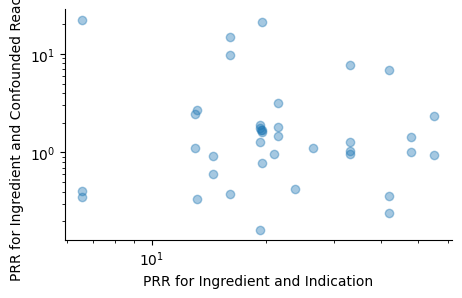

In [59]:
# build datafraem to look at confounding by indication
ind_keep = ['drug', 
        'reaction', 
        'indication',
        'PRR_ing_rxn',
        'PRR_ind_ing',
        'PRR_ind_rxn']
ind_merged = drug_rxn.merge(ind_ing, 
                            on='drug',
                            suffixes=('_ing_rxn', '_ind_ing')
                          ).merge(ind_rxn,
                            on=('indication', 'reaction',),
                            suffixes=('', '_ind_rxn'))

ind_merged.rename(columns={'PRR': 'PRR_ind_rxn'}, inplace=True)
ind_reduced = ind_merged[ind_keep]
# reduced[reduced['reaction']=='35506628'].head()

# plt.figure(figsize=(5,3))
# plt.hist(ind_reduced[ind_reduced['PRR_ind_rxn']>1]['PRR_ind_rxn'], bins=100)

print(f"Ind PRRs greatrer than 10: {(ind_reduced['PRR_ind_rxn'] > 10).sum()}")

# we only care about whent the relationship between the indication and the reaction is high
ind_rxn_high = ind_reduced[ind_reduced['PRR_ind_rxn'] > 10]
print(ind_rxn_high.shape)

plt.figure(figsize=(5,3))
plt.scatter(ind_rxn_high['PRR_ind_ing'], ind_rxn_high['PRR_ing_rxn'], alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('PRR for Ingredient and Indication')
plt.ylabel('PRR for Ingredient and Confounded Reaction')
sns.despine()

sp.stats.spearmanr(ind_rxn_high['PRR_ind_ing'], ind_rxn_high['PRR_ing_rxn'])